## CS 504 Final Project

### Team Name: TopGun

### Collaborative Filtering - Ullman Method

#### Team Members: 

Yeswanth Ravichandran G01480449

Surthesh Velu Samy - G01520635

Aakiff Panjwani - G01465365

Importing Necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from collections import defaultdict
from sklearn.metrics import pairwise_distances
from math import sqrt
from sklearn.metrics import mean_squared_error
import time

import warnings
warnings.filterwarnings('ignore')

Loading the Datasets "ratings" & 'movies'

In [2]:
ratings = pd.read_csv('../Dataset/ratings.csv')

In [3]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
movies = pd.read_csv('../Dataset/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


#### Summary Statistics

In [5]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [6]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [7]:
ratings.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [8]:
# Unique counts
print(f"Number of unique users: {ratings['userId'].nunique()}")
print(f"Number of unique movies: {ratings['movieId'].nunique()}")
print(f"Number of unique genres: {movies['genres'].nunique()}")

# Check for missing values
print(ratings.isnull().sum())
print(movies.isnull().sum())


Number of unique users: 610
Number of unique movies: 9724
Number of unique genres: 951
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
movieId    0
title      0
genres     0
dtype: int64


#### Exploratory Data Analysis

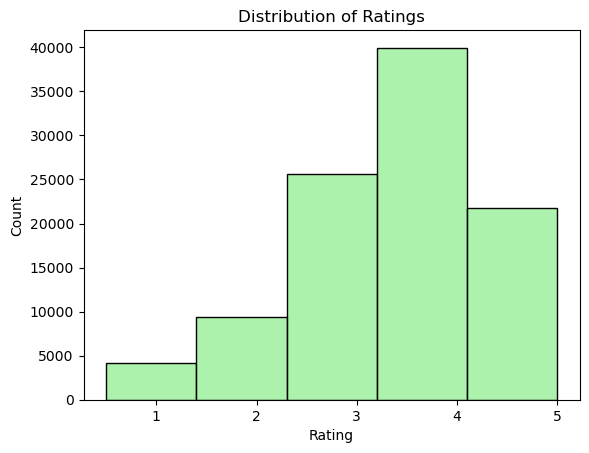

In [9]:
sns.histplot(ratings['rating'], bins=5, kde=False, color='lightgreen')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


In [10]:
# Count of ratings per movie
movie_ratings_count = ratings.groupby('movieId')['rating'].count().sort_values(ascending=False)
print(movie_ratings_count.head())

movieId
356     329
318     317
296     307
593     279
2571    278
Name: rating, dtype: int64


In [11]:
# Average rating per movie
movie_ratings_avg = ratings.groupby('movieId')['rating'].mean().sort_values(ascending=False)
print(movie_ratings_avg.head())

movieId
88448     5.0
100556    5.0
143031    5.0
143511    5.0
143559    5.0
Name: rating, dtype: float64


In [12]:
# Merge with movies dataset to get titles
popular_movies = movies.merge(movie_ratings_count, on='movieId', how='left')
popular_movies.columns = ['movieId', 'title', 'genres', 'rating_count']
display(popular_movies.head())

,movieId,title,genres,rating_count
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,215.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,110.0
2,3,Grumpier Old Men (1995),Comedy|Romance,52.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,7.0
4,5,Father of the Bride Part II (1995),Comedy,49.0


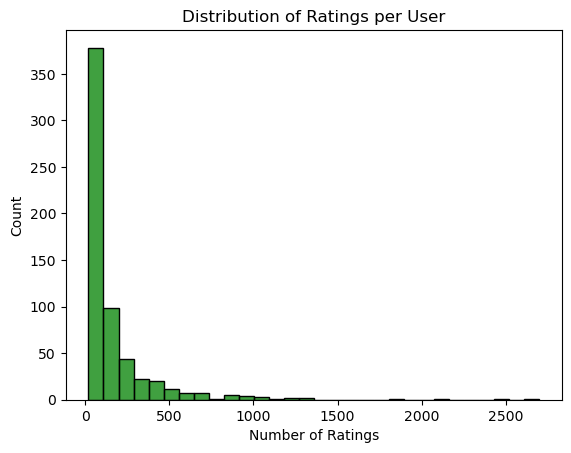

In [13]:
user_ratings_count = ratings.groupby('userId')['rating'].count()

# Plot user activity distribution
sns.histplot(user_ratings_count, bins=30, kde=False, color='green')
plt.title('Distribution of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Count')
plt.show()


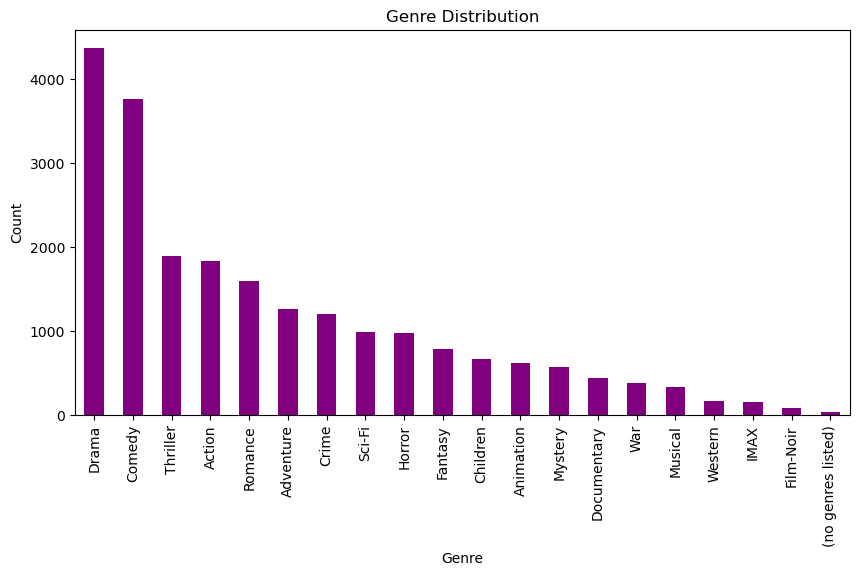

In [14]:
movies['genres_list'] = movies['genres'].str.split('|')
all_genres = movies.explode('genres_list')['genres_list']
genre_count = all_genres.value_counts()

genre_count.plot(kind='bar', color='purple', figsize=(10, 5))
plt.title('Genre Distribution')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.show()


#### Collaborative Filtering (CF)

#### Ullman Method 

The `calculation_ullman` function computes the similarity matrix using Pearson correlation between movies, while handling NaN values by replacing them with zeros. The `prediction_ullman` function predicts ratings by calculating a weighted sum of the movie-centered matrix, normalizing by the sum of weights, and adding the user's mean ratings. The `calculate_rmse` function computes the Root Mean Squared Error (RMSE) between true and predicted ratings, excluding NaN values to ensure accurate error measurement.

In [15]:
# Ullman Method with NaN and Division Handling
def calculation_ullman(movie_centered):
    similarity_matrix = np.corrcoef(movie_centered.T)
    similarity_matrix = np.nan_to_num(similarity_matrix, nan=0.0)  
    return similarity_matrix

# Prediction Function
def prediction_ullman(similarity_matrix, movie_centered, user_means):
    weighted_sum = similarity_matrix.dot(movie_centered.T)
    sum_of_weights = np.abs(similarity_matrix).sum(axis=1, keepdims=True)
    sum_of_weights[sum_of_weights == 0] = 1e-10  # to Avoid divide by zero
    predictions = weighted_sum / sum_of_weights

    user_means_aligned = user_means.values[:, np.newaxis]
    return predictions.T + user_means_aligned

# Function to calculate RMSE
def calculate_rmse(y_true, y_pred):
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]
    rmse = sqrt(mean_squared_error(y_true_filtered, y_pred_filtered))
    return rmse

#### 60-40 train-test split

The ratings data is split into training and testing sets in 60% and 40% respectively. Movie ratings are centered around their averages, and a similarity matrix is computed to predict missing ratings in the test set. The predicted ratings are adjusted by the user's mean and then merged with the test data, with the final predictions rounded to one decimal point.

In [16]:
runtimes = []
rmses = []

In [17]:
start_time = time.time()

# Split data into train and test sets
train_df, test_df = train_test_split(ratings, test_size=0.4, random_state=5)

# Calculate movie averages and center around these averages
movie_averages = train_df.groupby('movieId')['rating'].mean()
train_pivot = train_df.pivot(index='userId', columns='movieId', values='rating')
movie_centered = train_pivot.sub(movie_averages, axis=1)

# Calculate similarity matrix using Ullman method
similarity_matrix = calculation_ullman(movie_centered.fillna(0))

user_means = train_pivot.mean(axis=1).fillna(0)
test_pivot = test_df.pivot(index='userId', columns='movieId', values='rating')
test_predictions = prediction_ullman(similarity_matrix, movie_centered.fillna(0), user_means)

# Converting test predictions back to DataFrame
test_predictions_df = pd.DataFrame(test_predictions, index=test_pivot.index, columns=train_pivot.columns)


test_df['predicted_rating'] = test_df.apply(
    lambda x: test_predictions_df.loc[x['userId'], x['movieId']] 
    if x['movieId'] in test_predictions_df.columns and x['userId'] in test_predictions_df.index 
    else np.nan, 
    axis=1
)

# Round the predicted ratings to 1 decimal point
test_df['predicted_rating'] = test_df['predicted_rating'].round(1)

#### Saving Predictions and RMSE Calculation

This code saves the test dataset with predicted ratings to a CSV file and calculates the RMSE. The runtime for the process is also measured and displayed, providing insights into the model's performance with a 60-40 train-test split.

In [18]:
# Save test_df with predictions to a CSV file
test_df_filename = '../Prediction_Results/ratings_predictions_40_cf.csv'
test_df.to_csv(test_df_filename)

# Prepare data for RMSE calculation
test_pivot_masked = test_pivot.where(~test_pivot.isna(), np.nan)
test_predictions_masked = test_predictions_df.reindex_like(test_pivot_masked)

# Compute RMSE
rmse = calculate_rmse(test_pivot_masked.values.flatten(), test_predictions_masked.values.flatten())
rmses.append(rmse)

print(f'RMSE for 60% train and 40% test split using Ullman method: {rmse:.4f}')
print(f'Saved test data with predictions to {test_df_filename}')
end_time = time.time()
runtime = end_time - start_time
runtimes.append(runtime)
print("Runtime of the code is {:.2f} seconds".format(runtime))

RMSE for 60% train and 40% test split using Ullman method: 0.9423
Saved test data with predictions to ../Prediction_Results/ratings_predictions_40_cf.csv
Runtime of the code is 9.01 seconds


#### 70-30 train-test split

In [19]:
start_time = time.time()

# Split data into train and test sets
train_df, test_df = train_test_split(ratings, test_size=0.3, random_state=5)

# Calculate movie averages and center around these averages
movie_averages = train_df.groupby('movieId')['rating'].mean()
train_pivot = train_df.pivot(index='userId', columns='movieId', values='rating')
movie_centered = train_pivot.sub(movie_averages, axis=1)

# Calculate similarity matrix using Ullman method
similarity_matrix = calculation_ullman(movie_centered.fillna(0))

# Predict ratings for test set
user_means = train_pivot.mean(axis=1).fillna(0)
test_pivot = test_df.pivot(index='userId', columns='movieId', values='rating')
test_predictions = prediction_ullman(similarity_matrix, movie_centered.fillna(0), user_means)

# Convert test_predictions back to DataFrame
test_predictions_df = pd.DataFrame(test_predictions, index=test_pivot.index, columns=train_pivot.columns)

test_df['predicted_rating'] = test_df.apply(
    lambda x: test_predictions_df.loc[x['userId'], x['movieId']] 
    if x['movieId'] in test_predictions_df.columns and x['userId'] in test_predictions_df.index 
    else np.nan, 
    axis=1
)

# Round the predicted ratings to 1 decimal point
test_df['predicted_rating'] = test_df['predicted_rating'].round(1)

Saving the predictions for 30% test data

In [20]:
# Save test_df with predictions to a CSV file
test_df_filename = '../Prediction_Results/ratings_predictions_30_cf.csv'
test_df.to_csv(test_df_filename)

# Prepare data for RMSE calculation
test_pivot_masked = test_pivot.where(~test_pivot.isna(), np.nan)
test_predictions_masked = test_predictions_df.reindex_like(test_pivot_masked)

# Compute RMSE
rmse = calculate_rmse(test_pivot_masked.values.flatten(), test_predictions_masked.values.flatten())
rmses.append(rmse)
print(f'RMSE for 70% train and 30% test split using Ullman method: {rmse:.4f}')
print(f'Saved test data with predictions to {test_df_filename}')
end_time = time.time()
runtime = end_time - start_time
runtimes.append(runtime)
print("Runtime of the code is {:.2f} seconds".format(runtime))

RMSE for 70% train and 30% test split using Ullman method: 0.9391
Saved test data with predictions to ../Prediction_Results/ratings_predictions_30_cf.csv
Runtime of the code is 10.15 seconds


#### 80-20 train-test split

In [21]:
start_time = time.time()

# Split data into train and test sets
train_df, test_df = train_test_split(ratings, test_size=0.2, random_state=5)

# Calculate movie averages and center around these averages
movie_averages = train_df.groupby('movieId')['rating'].mean()
train_pivot = train_df.pivot(index='userId', columns='movieId', values='rating')
movie_centered = train_pivot.sub(movie_averages, axis=1)

# Calculate similarity matrix using Ullman method
similarity_matrix = calculation_ullman(movie_centered.fillna(0))

# Predict ratings for test set
user_means = train_pivot.mean(axis=1).fillna(0)
test_pivot = test_df.pivot(index='userId', columns='movieId', values='rating')
test_predictions = prediction_ullman(similarity_matrix, movie_centered.fillna(0), user_means)

# Convert test_predictions back to DataFrame
test_predictions_df = pd.DataFrame(test_predictions, index=test_pivot.index, columns=train_pivot.columns)

# Map predictions to test_df
test_df['predicted_rating'] = test_df.apply(
    lambda x: test_predictions_df.loc[x['userId'], x['movieId']] 
    if x['movieId'] in test_predictions_df.columns and x['userId'] in test_predictions_df.index 
    else np.nan, 
    axis=1
)
# Round the predicted ratings to 1 decimal point
test_df['predicted_rating'] = test_df['predicted_rating'].round(1)


Saving the predictions for 20% test data

In [22]:
# Save test_df with predictions to a CSV file
test_df_filename = '../Prediction_Results/ratings_predictions_20_cf.csv'
test_df.to_csv(test_df_filename)

# Prepare data for RMSE calculation
test_pivot_masked = test_pivot.where(~test_pivot.isna(), np.nan)
test_predictions_masked = test_predictions_df.reindex_like(test_pivot_masked)

# Compute RMSE
rmse = calculate_rmse(test_pivot_masked.values.flatten(), test_predictions_masked.values.flatten())
rmses.append(rmse)
print(f'RMSE for 80% train and 20% test split using Ullman method: {rmse:.4f}')
print(f'Saved test data with predictions to {test_df_filename}')
end_time = time.time()
runtime = end_time - start_time
runtimes.append(runtime)
print("Runtime of the code is {:.2f} seconds".format(runtime))

RMSE for 80% train and 20% test split using Ullman method: 0.9338
Saved test data with predictions to ../Prediction_Results/ratings_predictions_20_cf.csv
Runtime of the code is 9.46 seconds


#### 90-10 train-test split

In [23]:
start_time = time.time()

# Split data into train and test sets
train_df, test_df = train_test_split(ratings, test_size=0.1, random_state=5)

# Calculate movie averages and center around these averages
movie_averages = train_df.groupby('movieId')['rating'].mean()
train_pivot = train_df.pivot(index='userId', columns='movieId', values='rating')
movie_centered = train_pivot.sub(movie_averages, axis=1)

# Calculate similarity matrix using Ullman method
similarity_matrix = calculation_ullman(movie_centered.fillna(0))

# Predict ratings for test set
user_means = train_pivot.mean(axis=1).fillna(0)
test_pivot = test_df.pivot(index='userId', columns='movieId', values='rating')
# Align test_pivot with train_pivot
test_pivot_aligned = test_pivot.reindex_like(train_pivot)

# Predict ratings using Ullman method
test_predictions = prediction_ullman(similarity_matrix, movie_centered.fillna(0), user_means)

# Convert test_predictions back to DataFrame
test_predictions_df = pd.DataFrame(test_predictions, index=train_pivot.index, columns=train_pivot.columns)

# Align test_predictions_df with test_pivot_aligned
test_predictions_aligned = test_predictions_df.reindex_like(test_pivot_aligned)

# Map predictions to test_df
test_df['predicted_rating'] = test_df.apply(
    lambda x: test_predictions_aligned.loc[x['userId'], x['movieId']] 
    if x['movieId'] in test_predictions_aligned.columns and x['userId'] in test_predictions_aligned.index 
    else np.nan, 
    axis=1
)

# Round the predicted ratings to 1 decimal point
test_df['predicted_rating'] = test_df['predicted_rating'].round(1)

Saving the predictions for 10% test data

In [24]:
# Save test_df with predictions to a CSV file
test_df_filename = '../Prediction_Results/ratings_predictions_10_cf.csv'
test_df.to_csv(test_df_filename)

# Prepare data for RMSE calculation
test_pivot_masked = test_pivot.where(~test_pivot.isna(), np.nan)
test_predictions_masked = test_predictions_df.reindex_like(test_pivot_masked)

# Compute RMSE
rmse = calculate_rmse(test_pivot_masked.values.flatten(), test_predictions_masked.values.flatten())
rmses.append(rmse)
print(f'RMSE for 90% train and 10% test split using Ullman method: {rmse:.4f}')
print(f'Saved test data with predictions to {test_df_filename}')
end_time = time.time()
runtime = end_time - start_time
runtimes.append(runtime)
print("Runtime of the code is {:.2f} seconds".format(runtime))

RMSE for 90% train and 10% test split using Ullman method: 0.9323
Saved test data with predictions to ../Prediction_Results/ratings_predictions_10_cf.csv
Runtime of the code is 7.94 seconds


In [25]:
runtimes

[9.013173818588257, 10.153796434402466, 9.458108186721802, 7.936206340789795]

In [26]:
rmses

[0.9423250059583147,
 0.9391103806424793,
 0.9338467051514422,
 0.9323034515623083]

#### Visualizing Runtimes based on the train test splits

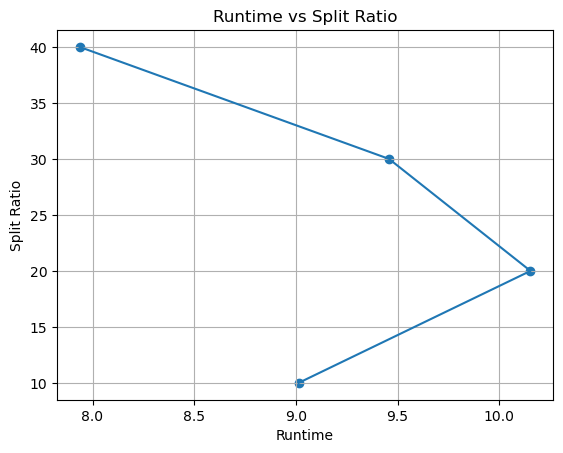

In [27]:
# Data
splits = [10, 20, 30, 40]

# Creating scatter plot
plt.scatter(runtimes, splits)
plt.plot(runtimes, splits)  
plt.grid(True)
plt.xlabel('Runtime')
plt.ylabel('Split Ratio')
plt.title('Runtime vs Split Ratio')

# Display the plot
plt.show()


The scatter plot shows the relationship between runtime and the train-test split ratio. As the split ratio increases from 10% to 40%, both the runtime and RMSE values decrease, indicating a slight reduction in computation time and prediction error as the training set size increases. This trend suggests that a larger training set (smaller test set) may lead to faster model performance, possibly due to reduced complexity in generating predictions, though the change is minimal within the tested split ratios.

#### Visualizing RMSE based on the train test splits

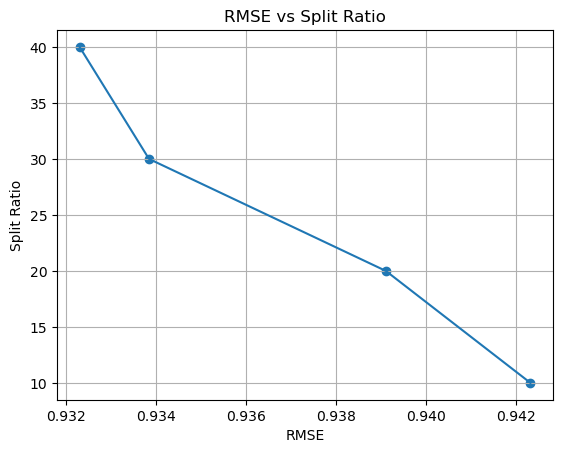

In [28]:
plt.scatter(rmses, splits)
plt.plot(rmses, splits) 
plt.grid(True)
plt.xlabel('RMSE')
plt.ylabel('Split Ratio')
plt.title('RMSE vs Split Ratio')

# Display the plot
plt.show()

The scatter plot of RMSE versus split ratio shows a slight downward trend as the train-test split ratio increases from 10% to 40%. This indicates that as the training set size grows (with a smaller test set), the model's prediction accuracy improves, reflected by a decrease in RMSE. A larger training set provides the model with more data to learn from, potentially leading to better generalization and lower prediction error. However, the change in RMSE is not drastic, suggesting the model is fairly stable across different split ratios within the tested range.

#### Recommendations

In [29]:
def recommend_movies_with_names(user_id, train_pivot, predictions_df, movies, n_recommendations=5):
    rated_movies = train_pivot.loc[user_id].dropna().index.tolist()
    user_predictions = predictions_df.loc[user_id].drop(rated_movies, errors='ignore')

    top_movies = user_predictions.sort_values(ascending=False).head(n_recommendations)
    recommendations = top_movies.reset_index().rename(columns={user_id: 'predicted_rating', 'movieId': 'movieId'})
    recommendations = recommendations.merge(movies[['movieId', 'title']], on='movieId', how='left')
    recommendations = recommendations.rename(columns={'title': 'Movie Title', 'predicted_rating': 'Predicted Rating', 'movieId': 'Movie ID'})
    return recommendations

# Recommendations of movies for the user
user_id = 5
recommendations_with_names = recommend_movies_with_names(user_id, train_pivot, test_predictions_df, movies, n_recommendations=10)
display(f"Movie recommendations for user {user_id}:", recommendations_with_names)

'Movie recommendations for user 5:'

,Movie ID,Predicted Rating,Movie Title
0,484,3.663241,Lassie (1994)
1,828,3.652661,"Adventures of Pinocchio, The (1996)"
2,617,3.651558,"Flower of My Secret, The (La flor de mi secret..."
3,142115,3.651050,The Blue Planet (2001)
4,6055,3.648182,Sugar Hill (1994)
5,97866,3.647735,"Imposter, The (2012)"
6,103107,3.645750,20 Feet from Stardom (Twenty Feet from Stardom...
7,4741,3.645064,Together (Tillsammans) (2000)
8,240,3.644663,Hideaway (1995)
9,2618,3.644326,"Castle, The (1997)"
